In [2]:
import wandb
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [3]:
# Make 1000 examples
n = 10000

In [4]:
# Create circles
X, y = make_circles(n, noise=0.03, random_state=0)

In [5]:
X.shape, y.shape

((10000, 2), (10000,))

In [7]:
type(y), type(X)

(numpy.ndarray, numpy.ndarray)

In [8]:
X[:10]

array([[ 0.59228267, -0.58450792],
       [ 0.44892322,  0.89715144],
       [-1.01094937,  0.15917766],
       [ 0.33432999,  0.71561032],
       [-0.98848906,  0.21187754],
       [-0.48483811, -0.61181906],
       [ 0.58885943,  0.50900607],
       [-0.20245236,  0.79125657],
       [-0.9353473 , -0.17091169],
       [-0.35379243, -0.9194312 ]])

In [9]:
y[:10]

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0])

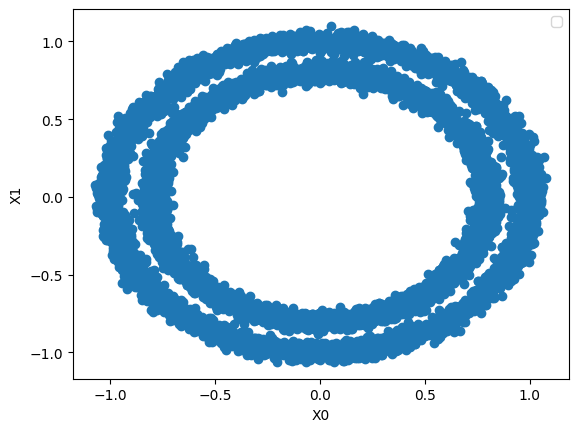

In [10]:
# Let's visualize the data
circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "Label": y})
plt.scatter(circles["X0"], circles["X1"])
plt.xlabel("X0")
plt.ylabel("X1")
plt.legend()

In [11]:
circles

,X0,X1,Label
0,0.592283,-0.584508,1
1,0.448923,0.897151,0
2,-1.010949,0.159178,0
3,0.334330,0.715610,1
4,-0.988489,0.211878,0
...,...,...,...
9995,0.453511,-0.632383,1
9996,0.952255,-0.151266,0
9997,-0.600848,-0.836835,0
9998,0.779310,-0.178889,1


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
# Model with Swish activation in the hidden layer
def swish_activation(x):
    return x * tf.sigmoid(x)

In [ ]:
# 1. Start a W&B run

wandb.init(project='First Project')

In [26]:
# 2. Save model inputs and hyperparameters

config = wandb.config

config.learning_rate = 0.01
config.epochs = 20
config.batch_size = 30

# Set the random seed so that we get the same random values
tf.random.set_seed(0)

## 1. Build Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation=swish_activation))
model.add(tf.keras.layers.Dense(10, activation="tanh"))
model.add(tf.keras.layers.Dense(1))

## 2. Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=["accuracy", tf.keras.metrics.Precision()],
)
## 3. Fit Model
model.fit(X_train, y_train, epochs=config.epochs, batch_size = config.batch_size, callbacks=[wandb.keras.WandbCallback()])

Epoch 1/20
250/250 [==============================] - 2s 3ms/step - loss: 0.7054 - accuracy: 0.7275 - precision_3: 0.7147
Epoch 2/20
250/250 [==============================] - 1s 3ms/step - loss: 0.1341 - accuracy: 0.9877 - precision_3: 0.9875
Epoch 3/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0208 - accuracy: 0.9975 - precision_3: 0.9977
Epoch 4/20
250/250 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9979 - precision_3: 0.9980
Epoch 5/20
250/250 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9966 - precision_3: 0.9955
Epoch 6/20
250/250 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9877 - precision_3: 0.9885
Epoch 7/20
250/250 [==============================] - 1s 2ms/step - loss: 0.0044 - accuracy: 0.9995 - precision_3: 0.9992
Epoch 8/20
250/250 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9996 - precision_3: 0.9995
Epoch 9/20
250/250 [====

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (32, 10)                  30        
                                                                 
 dense_7 (Dense)             (32, 10)                  110       
                                                                 
 dense_8 (Dense)             (32, 1)                   11        
                                                                 
Total params: 151 (604.00 Byte)
Trainable params: 151 (604.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


5408/5408 [==============================] - 8s 2ms/step


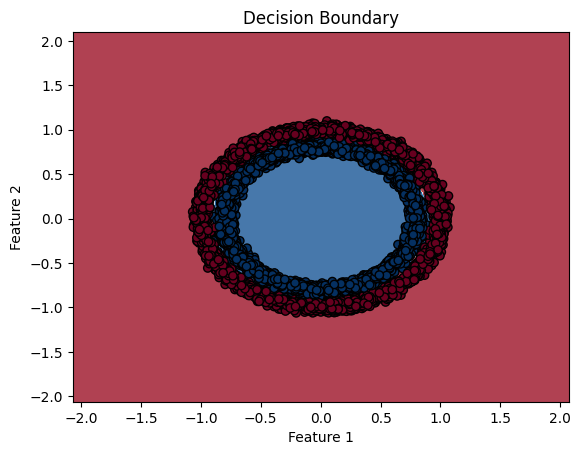

In [27]:
def plot_decision_boundary(model, X, y, threshold=0.5, cmap="RdBu"):
    # Generate a grid of points covering the input space
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Make predictions for each point in the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Apply threshold to convert probabilities into class predictions
    Z = (Z > threshold).astype(int)

    # Reshape predictions to match grid shape
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.8)

    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors="k")

    # Set plot limits
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Add labels and title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")

    # Show plot
    plt.show()


plot_decision_boundary(model=model, X=X_train, y=y_train)

In [29]:
eval = model.evaluate(X_test, y_test)

63/63 [==============================] - 1s 4ms/step - loss: 0.0024 - accuracy: 0.9990 - precision_3: 0.9990
